<a href="https://colab.research.google.com/github/Ghassanee/Crow_search/blob/main/Energy_comsumption_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import scipy
import math
import collections
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id="section-one"></a>
# 1. Preparation, cleaning and formatting

In [ ]:
!wget https://github.com/Ghassanee/Crow_search/raw/main/World%20Energy%20Consumption.csv
!wget https://github.com/Ghassanee/Crow_search/blob/main/Smart_Cities_dataset_for_Tableau.csv
!wget https://github.com/Ghassanee/Crow_search/blob/main/ghg-emissions.csv

--2022-12-28 21:19:43--  https://github.com/Ghassanee/Crow_search/raw/main/World%20Energy%20Consumption.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ghassanee/Crow_search/main/World%20Energy%20Consumption.csv [following]
--2022-12-28 21:19:43--  https://raw.githubusercontent.com/Ghassanee/Crow_search/main/World%20Energy%20Consumption.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5325796 (5.1M) [text/plain]
Saving to: ‘World Energy Consumption.csv’

World Energy Consum 100%[===================>]   5.08M  --.-KB/s    in 0.08s   

2022-12-28 21:19:43 (62.7 MB/s) - ‘World Energy Consump

In [ ]:
d=pd.read_csv('/content/World Energy Consumption.csv')

In [ ]:
d.head()

,iso_code,country,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,solar_elec_per_capita,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita
0,AFG,Afghanistan,1900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1901,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,1902,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,1903,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,1904,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17432 entries, 0 to 17431
Columns: 122 entries, iso_code to wind_energy_per_capita
dtypes: float64(119), int64(1), object(2)
memory usage: 16.2+ MB


In [ ]:
missing=d.isnull().sum()
n=missing.sum()/np.product(d.shape)
n
# seems a lot of data is missing and by picking different timeframes, you may see that there is more data for recent years,
#If we remove all rows with missing data, only little portion of it will remain

0.6808610883319917

### seems a lot of data is missing and by picking different timeframes, you may see that there is more data for recent years,
### If we remove all rows with missing data, only little portion of it will remain

In [ ]:
# Creating a dataframe with the detailed calculations of % of missing values.
missingna=d.isna().sum() / len(d) * 100 
missingna[missingna>0].sort_values(ascending=False)
missingnadf=pd.DataFrame(missingna)
pd.set_option('display.max_rows', 122)
missingnadf.head(10)

,0
iso_code,10.337311
country,0.000000
year,0.000000
coal_prod_change_pct,57.291189
coal_prod_change_twh,40.374025
gas_prod_change_pct,72.108765
gas_prod_change_twh,54.721202
oil_prod_change_pct,62.591785
oil_prod_change_twh,50.866223
energy_cons_change_pct,43.540615


In [ ]:
# Focus on the recent data: as data for the earliest years is missing I will further focus on the most recent decades where 
#more raw data is availabe
# There are a lot of null values and replacement of some of them will lead to the fact that a lot of data will be missing,
#so let's replace Nulls with forward/backward filling.
d.replace([np.inf, -np.inf], np.nan, inplace=True)
d=d.fillna(method='ffill').fillna(method='bfill')

In [ ]:
# Formatted floats to avoid scientific notations 

pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
d.describe()

# It is clear that data reqiored cleaning (some Inf, NaN values), as well as probably some outliers. Also the 'year' columns needs to be converted to integer. 

,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,energy_cons_change_twh,biofuel_share_elec,...,solar_elec_per_capita,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita
count,"17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00",...,"17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00"
mean,"1,973.09",1.41,7.71,"53,596,431,849,477.98",22.41,11.27,18.48,3.70,38.94,1.82,...,56.82,231.44,"592,751,650,164.06",2.64,47.34,1.79,14.56,128.96,157.39,651.74
std,34.33,456.89,113.32,"7,076,352,952,046,622.00",119.52,218.23,168.17,19.62,273.06,4.07,...,131.62,337.33,"3,767,631,093,166.42",5.91,"2,035.47",3.11,60.33,555.56,394.49,"1,155.95"
min,"1,900.00",-100.00,"-2,326.87",-100.00,"-1,054.32",-100.00,"-2,239.74",-92.63,"-6,083.41",0.00,...,0.00,0.00,"196,308,000.00",0.00,-100.00,0.00,-10.41,0.00,0.00,0.00
25%,"1,946.00",-4.07,0.00,-2.16,0.00,-2.74,-0.05,-1.01,-0.15,0.00,...,0.00,1.87,"17,433,516,032.00",0.00,6.17,0.00,0.00,0.00,0.00,0.00
50%,"1,983.00",0.00,0.00,0.00,0.00,0.00,0.00,2.27,0.46,0.09,...,1.52,51.81,"62,722,076,672.00",0.01,14.18,0.42,0.18,1.68,0.14,81.76
75%,"2,002.00",3.38,0.21,3.61,2.45,3.18,2.74,6.16,7.97,1.37,...,29.97,413.25,"253,000,000,000.00",2.01,28.20,2.53,3.07,18.02,64.36,863.17
max,"2,020.00","44,965.75","3,060.59","934,293,000,000,000,000.00","2,112.97","25,500.00","2,790.61","1,487.99","6,446.81",33.91,...,825.09,"1,763.67","107,000,000,000,000.00",56.34,"242,384.84",20.66,428.74,"3,540.05","2,825.43","6,928.36"


In [ ]:
#Convertinf float dates to integers

d['year']=pd.to_datetime(d['year'], format='%Y')
d['year']=d['year'].dt.year

In [ ]:
# Adding one more column with additional calculation

d['gdp_per_capita']=d['gdp']/d['population']

In [ ]:
# Final check for Null and NaNs values:

d.isnull().sum()
nandf=d[d.isna().any(axis=1)]
nandf

,iso_code,country,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita


In [ ]:
d.notnull().sum()

iso_code                  17432
country                   17432
year                      17432
coal_prod_change_pct      17432
coal_prod_change_twh      17432
                          ...  
wind_cons_change_twh      17432
wind_consumption          17432
wind_elec_per_capita      17432
wind_energy_per_capita    17432
gdp_per_capita            17432
Length: 123, dtype: int64

In [ ]:
# Looking at all countries list to check if there are regions in the list

l=[]        
x=[l.append(i) for i in d['country'] if i not in l]

In [ ]:
# Assigning indexies for columns to furhter explore separately
x=-1
for column in d.columns:
    x+=1
    print(x, column)

0 iso_code
1 country
2 year
3 coal_prod_change_pct
4 coal_prod_change_twh
5 gas_prod_change_pct
6 gas_prod_change_twh
7 oil_prod_change_pct
8 oil_prod_change_twh
9 energy_cons_change_pct
10 energy_cons_change_twh
11 biofuel_share_elec
12 biofuel_elec_per_capita
13 biofuel_cons_change_pct
14 biofuel_share_energy
15 biofuel_cons_change_twh
16 biofuel_consumption
17 biofuel_cons_per_capita
18 carbon_intensity_elec
19 coal_share_elec
20 coal_cons_change_pct
21 coal_share_energy
22 coal_cons_change_twh
23 coal_consumption
24 coal_elec_per_capita
25 coal_cons_per_capita
26 coal_production
27 coal_prod_per_capita
28 electricity_generation
29 biofuel_electricity
30 coal_electricity
31 fossil_electricity
32 gas_electricity
33 hydro_electricity
34 nuclear_electricity
35 oil_electricity
36 other_renewable_electricity
37 other_renewable_exc_biofuel_electricity
38 renewables_electricity
39 solar_electricity
40 wind_electricity
41 energy_per_gdp
42 energy_per_capita
43 fossil_cons_change_pct
44 foss

In [ ]:
d.describe()

,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,energy_cons_change_twh,biofuel_share_elec,...,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita
count,"17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00",...,"17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00"
mean,"1,973.09",1.41,7.71,"53,596,431,849,477.98",22.41,11.27,18.48,3.70,38.94,1.82,...,231.44,"592,751,650,164.06",2.64,47.34,1.79,14.56,128.96,157.39,651.74,"2,469,273.01"
std,34.33,456.89,113.32,"7,076,352,952,046,622.00",119.52,218.23,168.17,19.62,273.06,4.07,...,337.33,"3,767,631,093,166.42",5.91,"2,035.47",3.11,60.33,555.56,394.49,"1,155.95","25,440,647.81"
min,"1,900.00",-100.00,"-2,326.87",-100.00,"-1,054.32",-100.00,"-2,239.74",-92.63,"-6,083.41",0.00,...,0.00,"196,308,000.00",0.00,-100.00,0.00,-10.41,0.00,0.00,0.00,49.15
25%,"1,946.00",-4.07,0.00,-2.16,0.00,-2.74,-0.05,-1.01,-0.15,0.00,...,1.87,"17,433,516,032.00",0.00,6.17,0.00,0.00,0.00,0.00,0.00,"2,182.36"
50%,"1,983.00",0.00,0.00,0.00,0.00,0.00,0.00,2.27,0.46,0.09,...,51.81,"62,722,076,672.00",0.01,14.18,0.42,0.18,1.68,0.14,81.76,"7,222.79"
75%,"2,002.00",3.38,0.21,3.61,2.45,3.18,2.74,6.16,7.97,1.37,...,413.25,"253,000,000,000.00",2.01,28.20,2.53,3.07,18.02,64.36,863.17,"28,556.91"
max,"2,020.00","44,965.75","3,060.59","934,293,000,000,000,000.00","2,112.97","25,500.00","2,790.61","1,487.99","6,446.81",33.91,...,"1,763.67","107,000,000,000,000.00",56.34,"242,384.84",20.66,428.74,"3,540.05","2,825.43","6,928.36","495,000,000.00"


In [ ]:
# Let's separate other regions to more major categores incl. "Other regions"

middleeast=['Middle East', 'Other Middle East']
asia=['Asia Pacific','Other Asia & Pacific']
cis=['Other CIS', 'CIS']
otherregions=['Other South America', 'Other Northern Africa', 'Other Southern Africa','Other Caribbean']
d['country']=d['country'].replace(asia, 'Asia Pacific')
d['country']=d['country'].replace(otherregions, 'Other regions')
d['country']=d['country'].replace(middleeast, 'Middle East')
d['country']=d['country'].replace(cis, 'CIS')

<a id="section-two"></a>
# 2. Energy Consumption

<a id="subsection-one"></a>
### 2.1 World Energy Consumption patterns

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


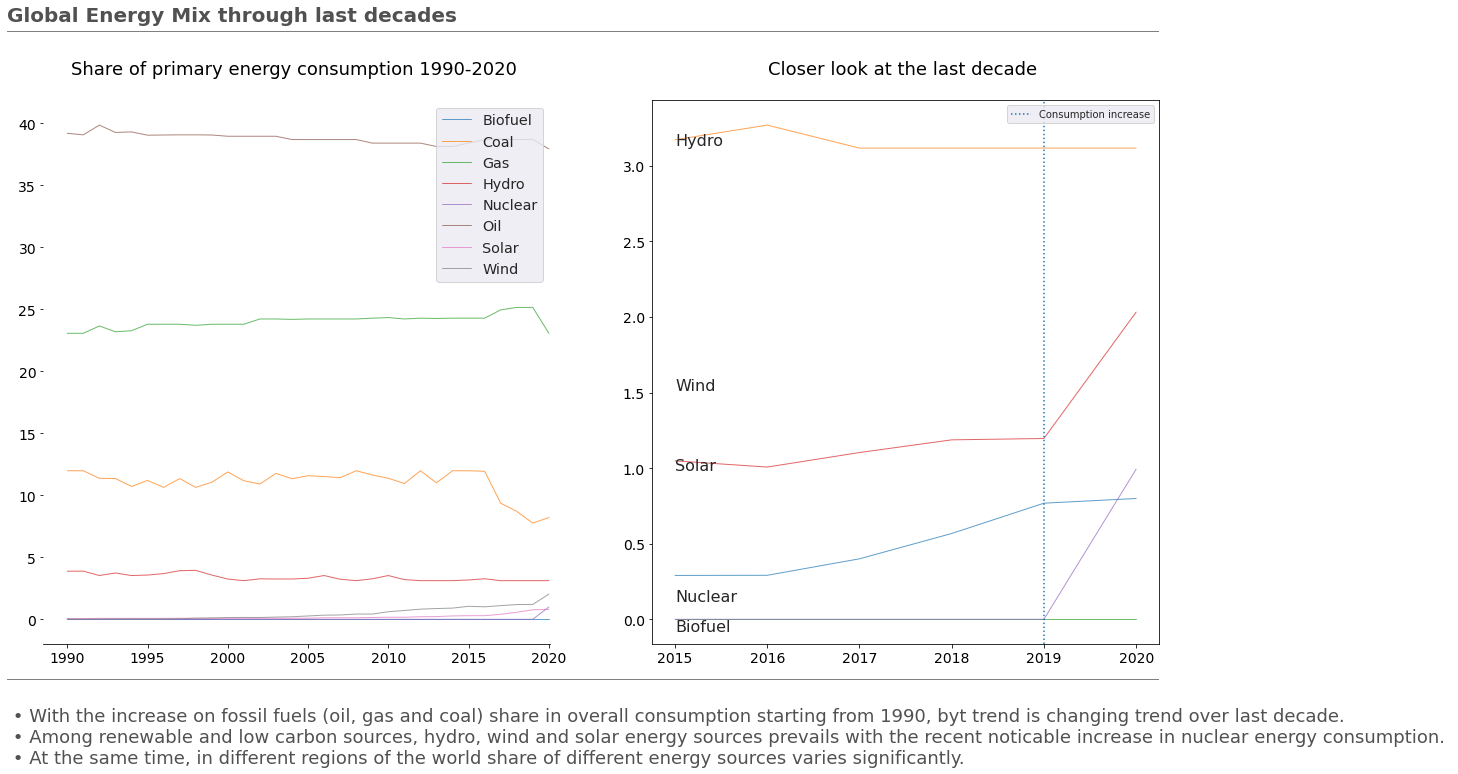

In [ ]:
# Let's have a look at the Primary energy sources consumption profiles for year 2000 and the latest available - 2020.

we=d.copy()
we=we.iloc[:, [1,2, 14, 21, 44, 52, 61, 70, 76, 83, 109, 117]]
we=we[(we['year'] >= 1990) & (we['year'] <= 2020)]

#Using median methon to avoid outliers.

we=we.groupby(by ='year', axis=0, as_index=False).median()

we.rename(columns = {'biofuel_share_energy': 'Biofuel', 'coal_share_energy': 'Coal', 'gas_share_energy': 'Gas', 'hydro_share_energy' : 'Hydro', 'nuclear_share_energy' : 'Nuclear', 'oil_share_energy' : 'Oil', 'solar_share_energy' :'Solar', 'wind_share_energy': 'Wind'}, inplace=True)

sources = ['Biofuel', 'Coal', 'Gas', 'Hydro', 'Nuclear', 'Oil', 'Solar', 'Wind']

we = pd.melt(we, id_vars='year', 
             value_vars=sources, 
             var_name='Energy source', 
             value_name='Share of primary energy consumption')

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.set_style(style='darkgrid')

#Creating the first plot with 1990-2020 data

for i in sources:
    axes[0].plot(we[we['Energy source'] == i]['year'], 
            we[we['Energy source'] == i]['Share of primary energy consumption'], 
            alpha =0.7, 
            linewidth =1, 
            fillstyle='full')


# Second plot with data on the last decade with the closer look at the renewable and lower carbon sources exclusively.

rlcsources = ['Solar',  'Hydro',  'Biofuel', 'Wind', 'Nuclear']

we1=we[(we['year'] >= 2015)&(we['year']<=2020)]  
we1.rename(columns = {'biofuel_share_energy': 'Biofuel', 'coal_share_energy': 'Coal', 'gas_share_energy': 'Gas', 'hydro_share_energy' : 'Hydro', 'nuclear_share_energy' : 'Nuclear', 'oil_share_energy' : 'Oil', 'solar_share_energy' :'Solar', 'wind_share_energy': 'Wind'}, inplace=True)

we1= we1[we1['Energy source'].isin(rlcsources)]

for j in rlcsources:
    axes[1].plot(we1[we1['Energy source'] == j]['year'], 
            we1[we1['Energy source'] == j]['Share of primary energy consumption'], 
            alpha=0.7, 
            linewidth=1)

year_start, year_end = 2015, 2020
names = we1[['Energy source', 'Share of primary energy consumption']][we1['year'] == year_end -1]

ad=0
for i, value in names.itertuples(index=False):
    axes[1].text(x=year_start, y=value + ad, s=i, va="top", size=16)
    ad+=0.1
    
#General settings

axes[0].set_title('Share of primary energy consumption 1990-2020 \n', size=18)
axes[1].set_title('Closer look at the last decade \n', size=18)
#axes[0].spines[['top','right','left']].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)

axes[1].set_xticks(np.arange(year_start, year_end +1))
axes[0].set_xlim([None, year_end + 0.1])

axes[0].legend(sources, loc='upper right', fontsize='x-large')
axes[1].legend(rlcsources, loc='upper right', fontsize='x-large')

axes[0].text(x=0.1, y=0.99, s="Global Energy Mix through last decades", transform=fig.transFigure, ha='left', fontsize=20, weight='bold', alpha=.8)
axes[0].add_patch(plt.Rectangle((0.1,0.075),              
                           0.8,                     
                           0.002,                      
                           facecolor='grey', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

axes[0].add_patch(plt.Rectangle((0.1,0.975),              
                           0.8,                     
                           0.002,                      
                           facecolor='grey', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

axes[0].text(x=0.1, y=-0.04, s=" • With the increase on fossil fuels (oil, gas and coal) share in overall consumption starting from 1990, byt trend is changing trend over last decade.\n • Among renewable and low carbon sources, hydro, wind and solar energy sources prevails with the recent noticable increase in nuclear energy consumption. \n • At the same time, in different regions of the world share of different energy sources varies significantly.", 
             transform=fig.transFigure, 
             ha='left', 
             fontsize=18, alpha=.8)

axes[0].xaxis.set_tick_params(labelsize=14) 
axes[1].xaxis.set_tick_params(labelsize=14) 
axes[0].yaxis.set_tick_params(labelsize=14) 
axes[1].yaxis.set_tick_params(labelsize=14) 

plt.axvline(x=2019, linestyle='dotted', label='Consumption increase')
plt.legend(loc = 'upper right')
plt.show()

### Animation: Historical Changes of World Energy Consumption Mix

In [ ]:
import plotly.express as px

# Focusing on columns with data on annual percentage change in energy sources consumption starting year 1990
consumption=d.copy()

consumption=consumption.iloc[:, [1, 2, 9, 13, 20, 43, 51, 60, 69, 75, 82, 108, 106, 92, 98, 114, 102, 41-42]]
consumption=consumption[consumption['year']>=1990]

# Central America removed due to it is the part of 'South and Central America' value.

regions=['World', 'Europe', 'Europe (other)','North America', 'Central America', 'South & Central America', 'CIS',  'South Africa', 'Eastern Africa', 'Other regions', 'Asia Pacific', 'Middle East']

consumption=consumption[consumption['country'].isin(regions)]

fig = px.bar(consumption, 
             x='country', y='energy_cons_change_pct', 
             color='country',
             animation_frame='year', 
             animation_group="country",
             range_y=[-15, 15], 
             labels={'energy_cons_change_pct': 'Energy consumption change, %'}, 
             title='Regional Changes in Energy Consumption from 1990, %')

fig.add_vrect(x0=11.5, x1=10.5)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

### Animation: Historical World Energy consumption per capita

In [ ]:
df=d.copy()

filt=df['year']>1970
w=df[filt].groupby('country').get_group('World')

# Interestingly enough is that the renewbles/lowe carbon energy consumption is increasing throughout the last decade as 
# The lower levels of general energy consumption significantly decreased during well-known global crisises like energy crisis in 1970-80s, in 2000s and mid-2010s and during pandemic as we will see later as well.

w.nsmallest(10, ['energy_cons_change_pct', 'fossil_cons_change_pct'])
w.nlargest(10, ['low_carbon_energy_per_capita','renewables_energy_per_capita'])

,iso_code,country,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita
17023,OWID_WRL,World,2019,1.52,698.28,3.42,"1,318.30",-0.33,-174.65,1.33,...,232.45,"107,000,000,000,000.00",5.47,12.14,2.18,383.21,"3,540.05",183.70,458.94,"13,871.84"
17024,OWID_WRL,World,2020,1.52,698.28,3.42,"1,318.30",-0.33,-174.65,1.33,...,232.45,"107,000,000,000,000.00",6.15,12.14,2.18,383.21,"3,540.05",204.01,458.94,"13,871.84"
17022,OWID_WRL,World,2018,5.03,"2,195.18",5.04,"1,849.83",2.41,"1,231.38",2.82,...,189.80,"107,000,000,000,000.00",4.95,10.67,1.97,304.42,"3,156.84",165.91,413.68,"14,021.59"
17021,OWID_WRL,World,2017,2.52,"1,071.37",3.73,"1,321.64",0.33,169.82,1.78,...,148.04,"107,000,000,000,000.00",4.62,17.69,1.83,428.74,"2,852.43",150.38,377.91,"14,176.21"
17020,OWID_WRL,World,2016,-5.18,"-2,326.87",1.14,397.18,0.37,185.18,1.37,...,110.59,"107,000,000,000,000.00",4.01,15.21,1.58,320.02,"2,423.69",128.47,324.72,"14,335.43"
17019,OWID_WRL,World,2015,-2.63,"-1,215.34",2.18,747.30,3.12,"1,534.11",0.73,...,88.04,"105,000,000,000,000.00",3.55,17.01,1.39,305.77,"2,103.67",112.29,285.06,"14,228.03"
17018,OWID_WRL,World,2014,-0.35,-163.00,2.03,680.63,2.32,"1,113.37",0.81,...,69.02,"102,000,000,000,000.00",3.14,10.45,1.20,170.17,"1,797.90",98.78,246.45,"13,981.62"
17017,OWID_WRL,World,2013,1.80,816.93,1.17,389.40,0.21,100.22,1.89,...,49.40,"99,300,000,000,000.00",2.85,19.04,1.09,260.39,"1,627.74",89.21,225.74,"13,771.43"
17014,OWID_WRL,World,2010,5.55,"2,203.03",7.20,"2,112.97",2.01,912.84,4.81,...,12.64,"88,500,000,000,000.00",1.67,24.75,0.64,179.25,903.47,49.80,129.87,"12,721.32"
17016,OWID_WRL,World,2012,1.15,515.76,2.06,669.60,2.79,"1,299.15",1.29,...,36.44,"96,600,000,000,000.00",2.42,19.75,0.94,225.50,"1,367.35",74.59,191.89,"13,556.32"


In [ ]:
# Now, focusing on per capita energy consumption patterns to visualize patterns related to the changes in GDP and energy mix consumption 

regions=['World', 'Europe', 'Europe (other)','North America', 'Central America', 'South & Central America', 'CIS',  'South Africa', 'Eastern Africa', 'Other regions', 'Asia Pacific', 'Middle East']

wemc=d.copy()
wemc=wemc[(wemc['year']>=1990)]
wemc=wemc.loc[wemc['country'].isin(regions)]
wemc=wemc.iloc[:, [1, 2, 42, 47, 98, 99, 122]]

px.scatter(wemc, x='population', y='primary_energy_consumption', 
           animation_frame="year", 
           animation_group="country",
           size='gdp_per_capita', 
           color="country", 
           hover_name="country",      
           size_max=55, 
           log_x=True,
           range_y=[-100, 100000],
           title='Primary energy consumption vs growing population <br><sup>Asia-Pacific with the largest GDP per capita is significantly increasing its primary energy consumption</sup>', 
           labels={'primary_energy_consumption': 'Energy consumption, kw/hrs', 'population': 'Population'})

From the plot above we can see that the highest GDP level in Asia-Pacific also correlated with the increase in primarly energy consumption throughout the years.

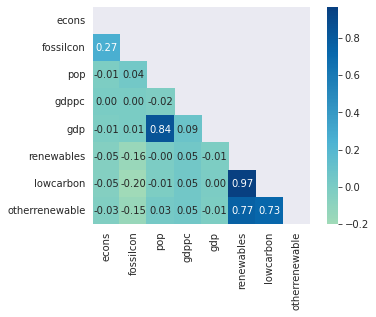

In [ ]:
# Looking at the correlation between main data like gdp per capita/population size/energy consumption etc.

wo=d.copy()
filt=wo['year']>1970
wo=wo[filt]
wo.drop_duplicates()

wo=wo[wo['country'].isin(regions)]

wo=pd.DataFrame().assign(
    country=d['country'], 
    econs=d['energy_cons_change_pct'], 
    fossilcon=d['fossil_cons_change_pct'], 
    pop=d['population'], 
    gdppc=d['gdp_per_capita'],
    gdp=d['gdp'],
    renewables=d['renewables_energy_per_capita'],
    lowcarbon=d['low_carbon_energy_per_capita'],
    otherrenewable=d['other_renewables_energy_per_capita'])

c=wo.corr()

# creating a mask
mask=np.triu(np.ones_like(c, dtype=bool))
sns.heatmap(c, mask=mask, center=0, annot=True, fmt='.2f', square=True, cmap="GnBu")

# c.style.background_gradient(cmap="GnBu")

plt.show()

# From the table and plots below we can see that there is: 

## consumption of renewables and low carbon energy sources are highly interrelated
## there is a little positive correlation (0.26) between the energy consumption and fossil fuels consumption meaning the rise of consumption specifically of fossil fuels 
## surprisingly, no correlation found between the gdp per capita and consumption of energy from rewewable sources.

<a id="subsection-two"></a>
## 2.2 Energy Consumption profile of countries with the highest GHG emissions

### Global historical GHG emissions

In [ ]:
# Let's upload GHG emissions data from Climate Watch used in the previous part of the project and convert wide data (years) to long:
ghg=pd.read_csv('/content/ghg-emissions.csv')
ghg.isna().sum()

Country/Region    0
unit              0
1990              2
1991              2
1992              2
1993              2
1994              2
1995              2
1996              2
1997              2
1998              2
1999              2
2000              2
2001              2
2002              2
2003              2
2004              2
2005              2
2006              2
2007              2
2008              2
2009              2
2010              2
2011              2
2012              2
2013              2
2014              2
2015              2
2016              2
2017              2
2018              2
2019              2
dtype: int64

In [ ]:
# We will need to find the top ten countries based on their GHG emissions level

ghg=pd.melt(ghg, id_vars='Country/Region',
            value_vars=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 
            value_name='ghg', 
            var_name='year', 
            ignore_index=False)

# Let's focus on the last decade since exactly then the renewables/low carbon energy consumption started increasing.
ghg['ghg'] = pd.to_numeric(ghg['ghg'], errors='coerce')
ghg=ghg[ghg['year']>='2010']
ghg.ghg.median()

37.885

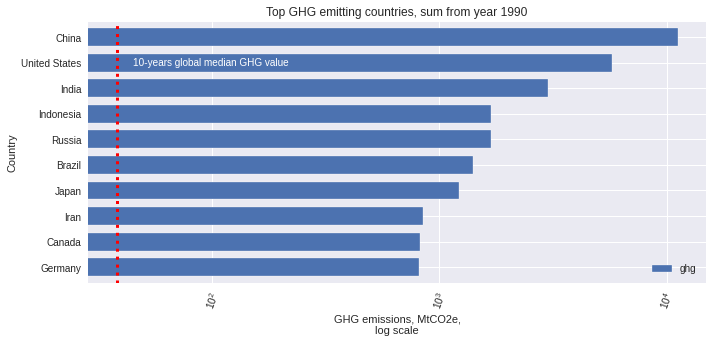

In [ ]:
# Choosing the top 10 countries with the largest amount of GHG emissions:

topghg=ghg.groupby('Country/Region', as_index=False).agg({'ghg': 'median'}).sort_values('ghg', ascending=False).head(10)
topghg.sort_values('ghg', ascending=False)

# Let's calculate the median value of GHG emission for the last 10 year for all countries for comparison

ghg=ghg[ghg['year']>='2010']
medianghg=ghg.ghg.median()

# Selecting top countries with the highest GHG emissions from the list of World Energy Consumption

t=[]
for c in topghg['Country/Region']:
    if c not in t:
        t.append(c)
        
ctbarh=topghg[topghg['Country/Region'].isin(t)].sort_values(by='ghg')

plt.style.use('seaborn')
ctbarh.plot.barh(x='Country/Region', y='ghg', width=0.7, figsize=(10,5))

plt.title('Top GHG emitting countries, sum from year 1990')
plt.ylabel('Country')
plt.xlabel('GHG emissions, MtCO2e,\nlog scale')
plt.xticks(rotation=70)
plt.axvline(x=38, linestyle='dotted',color='red', linewidth=3)
plt.text(x=45, y=7.9, s='10-years global median GHG value', color='white')
plt.tight_layout()
plt.xscale('log')
plt.show()

In [ ]:
import plotly.express as px

ct=ghg[ghg['Country/Region'].isin(t)]

fig = px.bar(ct, x='Country/Region', y='ghg', color='Country/Region',
             animation_frame="year", 
             animation_group="Country/Region", 
             range_y=[0, 13000], 
             title=('Total GHG emissions, CO2e: top 10 emitters<br><sup>China and the USA are leading the list with the highest GHG emissions levels</sup>'),
             labels={'ghg': 'Greenhouse gases emissions, ', 'gdp_per_capita': 'GDP per capita', 'Country/Region': 'Region'})
plt.tight_layout()                
fig.show()

<Figure size 576x396 with 0 Axes>

China
United States
India
Indonesia
Russia
Brazil
Japan
Iran
Canada
Saudi Arabia
Germany
Democratic Republic of the Congo
Mexico
South Korea
Australia
South Africa
Turkey
Pakistan
Vietnam
Thailand
United Kingdom
Argentina
Malaysia
Italy
Nigeria
France
Egypt
Iraq
Poland
Venezuela
Spain
Algeria
Kazakhstan
Colombia
United Arab Emirates
Myanmar
Bangladesh
Philippines
Ukraine
Peru
Uzbekistan
Ethiopia
Netherlands
Turkmenistan
Tanzania
Bolivia
Kuwait
Angola
Sudan
Libya
Cameroon
Zimbabwe
Qatar
Czech Republic
Belgium
Mozambique
Chad
Oman
Ecuador
Paraguay
Zambia
Morocco
Israel
North Korea
Greece
Romania
Kenya
New Zealand
Cambodia
Austria
Singapore
Belarus
Papua New Guinea
Hungary
Serbia
Portugal
South Sudan
Mongolia
Uganda
Ireland
Finland
Burkina Faso
Chile
Bahrain
Azerbaijan
Botswana
Côte d'Ivoire
Syria
Nepal
Central African Republic
Solomon Islands
Switzerland
Mali
Denmark
Niger
Somalia
Guinea
Madagascar
Dominican Republic
Laos
Guatemala
Nicaragua
Cuba
Sri Lanka
Tunisia
Slovakia
Jordan
Lebanon
Uruguay
Senegal
Republic of Congo
Sweden
Afghanistan
Trinidad and Tobago
Honduras
Norway
Benin
Panama
Yemen
Bosnia and Herzegovina
Namibia
Guyana
Gabon
Malawi
Lithuania
Croatia
Georgia
Bulgaria
Tajikistan
Slovenia
Liberia
Equatorial Guinea
Estonia
El Salvador
Suriname
Kyrgyzstan
Moldova
Mauritania
Ghana
Macedonia
Haiti
Luxembourg
Jamaica
Armenia
Brunei
Sierra Leone
Latvia
Albania
Togo
Costa Rica
Cyprus
Burundi
Rwanda
Belize
Mauritius
Eritrea
Timor-Leste
Guinea-Bissau
Montenegro
Barbados
Bahamas
Gambia
Iceland
Eswatini
Maldives
Lesotho
Grenada
Malta
Djibouti
Antigua and Barbuda
Vanuatu
Samoa
Seychelles
Cape Verde
Saint Lucia
Comoros
Andorra
Sao Tome and Principe
Bhutan
Saint Kitts and Nevis
Saint Vincent and the Grenadines
Tonga
Palau
Marshall Islands
Micronesia
Dominica
Liechtenstein
Kiribati
Cook Islands
Nauru
Tuvalu
Niue
Fiji

In [ ]:
import plotly.express as px
consumptionpersource=d.copy()
consumptionpersource=consumptionpersource.iloc[:, [1, 2, 17, 25, 56, 65, 73, 80, 87, 96, 106, 113, 121]]
consumptionpersource=consumptionpersource.fillna(method='ffill').fillna(method='bfill')
consumptionpersource=consumptionpersource[consumptionpersource['year']>=2000]
consumptionpersource['year']=pd.to_datetime(consumptionpersource['year'], format='%Y')
consumptionpersource['year']=consumptionpersource['year'].dt.year
consumptionpersource=consumptionpersource[consumptionpersource['country'].isin(t)]

fig = px.bar(consumptionpersource, 
             x="country", y=['other_renewables_energy_per_capita', 'oil_energy_per_capita', 'nuclear_energy_per_capita', 'hydro_energy_per_capita',
                             'gas_energy_per_capita','coal_cons_per_capita', 'biofuel_cons_per_capita','solar_energy_per_capita', 'wind_energy_per_capita'], 
             title="Consumption Profiles per capita, top emitters",
             color_discrete_map={
                'coal_cons_per_capita':'black',
                'gas_energy_per_capita': '#F0F8FF',
                'oil_energy_per_capita': "#B8860B",
                'nuclear_energy_per_capita': "#E0EEEE",
                'hydro_energy_per_capita': "#00FFFF",
                'biofuel_cons_per_capita': '#228B22',
                'solar_energy_per_capita': '#FFFF00', 
                'wind_energy_per_capita':'#F8F8FF',
                'other_renewables_energy_per_capita': "magenta"}, 
             animation_frame="year", 
             animation_group="country",                         
             range_y=[0, 200000])
plt.tight_layout()
fig.show()

<Figure size 576x396 with 0 Axes>

<a id="subsection-three"></a>
### 2.3 Energy Consumption profiles for countries with top Smart Cities: focus on Renewables and Low Carbon sources

In [ ]:
# Importing list of Smart Cities from the dataset used in part 2 of the project to join with World Energy Consumption data. The smart cities has been ranked with accordance to their performace measured by IMD Smart Cities Index methodology with the 1st rank being the best.
# We need to check if spellings of countries' names are the same in both lists by comparing them:

sci=pd.read_csv('/content/Smart_Cities_dataset_for_Tableau.csv')
sci=sci.iloc[:, [0,1, 4 , 6]]

countries=[]

for country in sci['Country']:
    if country not in countries: 
        countries.append(country)

#Preparing a list of countries from the World Energy dataset to compate countries names in both
        
d.groupby('country')

countriesall=[]
for country in d['country']:
    if country not in countriesall: 
        countriesall.append(country)

#Here is the list of countries missing from the IMD Smart City countries' list in the full list of countries due to difference in spelling, so further will replace names of those.

comparison=[]
for i in countries:
    if i not in countriesall:
        comparison.append(i)
comparison 

['Czech\xa0Republic',
 'Korea,\xa0Rep.',
 'Korea,\xa0Rep. ',
 'Russian Federation',
 'Slovak\xa0Republic',
 'Egypt, Arab Rep.']

In [ ]:
# Now replacing the names in the Smart Cities dataset to those in the World Energy one so that we could now select countries from both datasets :
sci['Country'].replace('UAE', 'United Arab Emirates', inplace=True)
sci['Country'].replace('The Netherlands', 'Netherlands', inplace=True)
sci['Country'].replace('UK', 'United Kingdom', inplace=True)
sci['Country'].replace('US', 'United States', inplace=True)
sci['Country'].replace('Singapore ', 'Singapore', inplace=True)
sci['Country'].replace('Isreal', 'Israel', inplace=True)   
temp = sci.sort_values('Ranking2020', ascending=True)

# Let's add the first 15 countries iterating through the list of Rankings for Smart Cities and add to the final list of countries with the best performing cities only those that are not in the list.

topsmartcountries=[]
x=0
for country in temp.Country:
    if country not in topsmartcountries and x<11:
        x+=1
        topsmartcountries.append(country)
topsmartcountries

['Singapore',
 'Finland',
 'Switzerland',
 'New Zealand',
 'Norway',
 'Denmark',
 'China',
 'Netherlands',
 'United States',
 'Germany',
 'Australia']

In [ ]:
sc=d.copy()
sc=sc.loc[sc['country'].isin(topsmartcountries)]
sc=sc.iloc[:, [1, 2,  73, 96, 98, 114, 106,  121]]
sc=sc[sc['year']>=2000]

#Calculation of total renewable and low carbon energy consumption per capita

sc['renewlowcarbon']=sc['low_carbon_energy_per_capita']+sc['other_renewables_energy_per_capita']+sc['renewables_energy_per_capita']
sc['gdp_per_capita']=sc['gdp']/sc['population']

px.scatter(sc, x='renewlowcarbon', y='gdp_per_capita', 
           animation_frame="year", animation_group="country",
           size='population', 
           color="country", 
           hover_name="country",
           log_x=True, 
           size_max=55, 
           title='Growth of renewables consumption in countries with Smart Cities<br><sup>Noticable growth in renewables and low carbon energy consumption throughout the last decade in countries with the best performing Smart Cities</sup>',
           labels={'renewlowcarbon': 'Consumption of renewable and low carbon energy, per capita', 'gdp_per_capita': 'GDP per capita'})

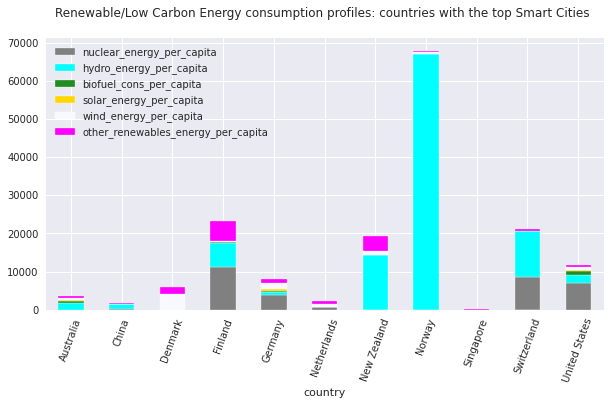

In [ ]:
# Let's look closer at the Renewable/ow Carbon Energy mix profile for those countries all together starting from 2015 again

scr=d.copy()
scr=scr.iloc[:, [1, 2, 17, 25, 56, 65, 73, 80, 87, 96, 106, 113, 121]]
scr=scr[scr['year']>2000]
scr=scr[scr['country'].isin(topsmartcountries)]

sns.set_style(style='darkgrid')

scr=scr.groupby('country', as_index=False).median().groupby('country', as_index=False).mean()
scr.plot(x='country', 
          y=['nuclear_energy_per_capita', 'hydro_energy_per_capita', 'biofuel_cons_per_capita', 'solar_energy_per_capita', 'wind_energy_per_capita', 'other_renewables_energy_per_capita'], 
          kind='bar', 
         stacked=True,
          figsize=(10, 5), 
          title='Renewable/Low Carbon Energy consumption profiles: countries with the top Smart Cities \n', 
          color={'coal_cons_per_capita':'black',
                'gas_energy_per_capita': '#F0F8FF',
                'oil_energy_per_capita': "#FFB90F",
                'nuclear_energy_per_capita': "grey",
                'hydro_energy_per_capita': "#00FFFF",
                'biofuel_cons_per_capita': '#228B22',
                'solar_energy_per_capita': '#FFD700', 
                'wind_energy_per_capita':'#F8F8FF',
                'other_renewables_energy_per_capita': "magenta"})
plt.xticks(rotation=70)
plt.show()

In [ ]:
fig = px.bar(scr, x="country",
             y=['other_renewables_energy_per_capita', 'oil_energy_per_capita', 'nuclear_energy_per_capita', 'hydro_energy_per_capita','gas_energy_per_capita','coal_cons_per_capita', 'biofuel_cons_per_capita','renewables_energy_per_capita', 'solar_energy_per_capita', 'wind_energy_per_capita'], 
             title="Historical perspective on Renewables and Low Carbon Consumption Profiles <br><sup>Countries with top Smart Cities performers, per capita</sup>",
            color_discrete_map={
                'coal_cons_per_capita':'black',
                'gas_energy_per_capita': '#F0F8FF',
                'oil_energy_per_capita': "#FFB90F",
                'nuclear_energy_per_capita': "#E0EEEE",
                'hydro_energy_per_capita': "#00FFFF",
                'biofuel_cons_per_capita': '#228B22',
                'solar_energy_per_capita': '#FFD700', 
                'wind_energy_per_capita':'#F8F8FF',
                'renewables_energy_per_capita':'#CAFF70',
                'other_renewables_energy_per_capita': "magenta"}, 
             animation_frame="year", 
             animation_group="country",
            range_y=[0, 200000])
plt.tight_layout()
fig.show()

<Figure size 576x396 with 0 Axes>

In [ ]:
wec=d[(d['year']>=2010)&(d['year']<=2020)]

wec= wec[wec["country"].isin(topsmartcountries)]
wec = wec.fillna(method="ffill").fillna(method="bfill")

wec['renlowcarbon'] = wec['other_renewables_energy_per_capita']+ wec['renewables_energy_per_capita']+ wec['low_carbon_energy_per_capita']

medianrenew = wec['renlowcarbon'].mean()

wec.groupby('country').median().sort_values(by=['renlowcarbon'], ascending=False).head(10)

,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,energy_cons_change_twh,biofuel_share_elec,...,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita,renlowcarbon
country,,,,,,,,,,,,,,,,,,,,,
Norway,"2,015.00",0.00,0.50,-0.30,-3.48,-5.31,-55.48,0.40,2.11,0.33,...,"400,000,000,000.00",1.58,20.78,1.09,0.83,5.64,430.77,"1,097.25","75,845.97","133,403.91"
Finland,"2,015.00",-21.12,0.00,-12.94,-10.95,-3.03,-5.36,-3.19,-10.70,16.82,...,"210,000,000,000.00",3.40,31.04,1.84,0.71,5.89,424.62,"1,074.21","38,141.72","44,356.00"
New Zealand,"2,015.00",-5.84,-1.31,-13.03,-42.07,0.00,0.64,0.96,2.35,1.42,...,"153,000,000,000.00",4.81,6.28,2.19,0.35,5.36,460.61,"1,167.55","33,152.76","42,698.46"
Switzerland,"2,015.00",0.00,-0.11,0.00,0.00,0.00,0.02,0.19,0.59,4.38,...,"518,000,000,000.00",0.17,8.26,0.09,0.02,0.27,13.01,32.71,"61,813.19","31,569.21"
United States,"2,015.00",-3.27,-188.10,5.15,355.77,11.18,568.49,-0.14,-36.45,1.47,...,"16,900,000,000,000.00",4.66,11.37,1.90,65.29,487.35,594.37,"1,518.79","52,269.31","18,518.07"
Denmark,"2,015.00",0.00,-0.81,-12.63,-7.57,-9.95,-8.67,-0.50,-0.98,14.48,...,"255,000,000,000.00",41.85,14.95,16.54,2.73,33.28,"2,309.06","5,876.35","44,823.34","18,418.86"
Germany,"2,015.00",-2.99,-15.37,-7.90,-6.01,0.00,3.66,1.21,45.63,7.85,...,"3,850,000,000,000.00",12.41,10.26,5.31,13.85,200.99,973.31,"2,445.34","46,936.55","16,521.74"
Australia,"2,015.00",0.67,24.23,15.32,93.95,-0.68,-1.69,1.44,22.68,1.38,...,"1,050,000,000,000.00",4.81,18.53,1.85,3.67,29.95,479.15,"1,251.40","43,522.47","9,493.60"
Netherlands,"2,015.00",0.00,-0.24,-13.00,-42.07,0.00,0.64,-0.42,-4.15,4.86,...,"821,000,000,000.00",6.85,8.06,1.96,1.57,19.10,445.74,"1,127.61","48,503.92","6,025.68"


In [ ]:
wec=d[(d['year']>=2010)&(d['year']<=2020)]
wec = wec.fillna(method="ffill").fillna(method="bfill")

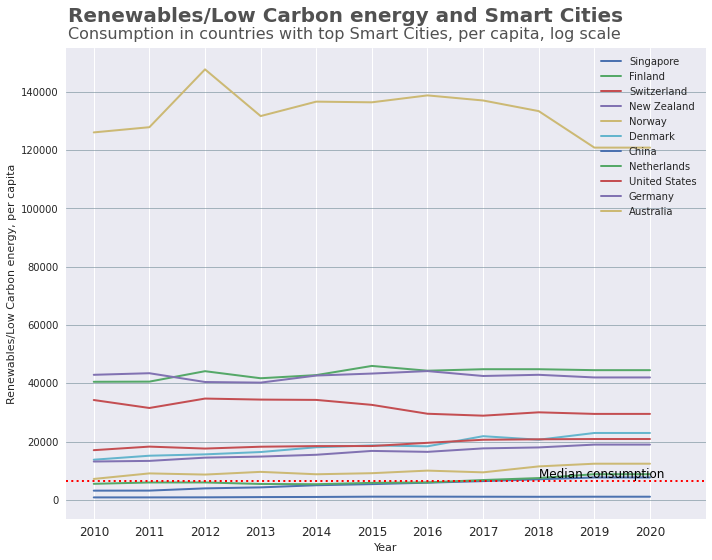

In [ ]:
wec=d[(d['year']>=2010)&(d['year']<=2020)]

wec = wec.fillna(method="ffill").fillna(method="bfill")

# Now calculating the columns with all renewables/low carbon sources consumption numbers:
wec['renlowcarbon'] = wec['other_renewables_energy_per_capita']+ wec['renewables_energy_per_capita']+ wec['low_carbon_energy_per_capita']


# Calculation of the median renewables/low carbon consumption for the last decade for all countries in the list
medianrenew = wec.groupby('country').agg('median').mean()
medianrenew = wec.renlowcarbon.median()

# Chosing countries that are in the list of those with Smart Cities

wec= wec[wec["country"].isin(topsmartcountries)]

# Plotting countries with top Smart Cities

column='renlowcarbon'

fig, ax = plt.subplots(figsize=(10,8))

sns.set_style(style='darkgrid')

ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)

for region in topsmartcountries:
    ax.plot(wec[wec['country'] == region]['year'], 
            wec[wec['country'] == region]['renlowcarbon'], 
            alpha=1, 
            linewidth=2)
       
ax.plot(wec[wec['country'] == 'World']['year'], 
        wec[wec['country'] == 'World']['renlowcarbon'], 
        color='grey',
        linewidth=3)

year_start, year_end = 2010, 2020

labels = wec[['country', column]][wec['year'] == year_end-1]

# add=0
# for region, value in labels.itertuples(index=False):
   # ax.text(x=year_start, y=value +add, s=region, va="center")
   # add=-1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks(np.arange(year_start, year_end +.1, 1))
ax.set_xlim([None, year_end + 1])

# Add in title and subtitle
ax.text(x=0.1, y=0.94, s="Renewables/Low Carbon energy and Smart Cities", transform=fig.transFigure, ha='left', fontsize=20, weight='bold', alpha=.8)
ax.text(x=0.1, y=0.91, s="Consumption in countries with top Smart Cities, per capita, log scale", transform=fig.transFigure, ha='left', fontsize=16, alpha=.8)
ax.legend(topsmartcountries, loc='upper right')
plt.xlabel('Year') 
ax.xaxis.set_tick_params(labelsize=12) 
plt.ylabel('Renewables/Low Carbon energy, per capita')
plt.axhline(y=medianrenew, linestyle='dotted', color='red', linewidth=2)
ax.annotate('Median consumption',xy=(2015,1000), xycoords='data', xytext=(2018, 7510), color='black', size=12)  
plt.tight_layout()
plt.show()

<a id="section-three"></a>
# 3. Energy Production patterns

<a id="subsection-one-one"></a>
## 3.1 Fossil fuels energy production profiles for countries with the highest GHG emissions levels (per capita) from 1990

In [ ]:
# Unfortunately, the datasets contains information about energy production for mainly fossil fules (oil, gas and coal).

p=d.copy()

p=p.iloc[:, [1, 2, 27, 58, 89]]
p=p[p['year']>=1990]
p=p.loc[p['country'].isin(t)]

p['ffprod']=p['coal_prod_per_capita']+p['gas_prod_per_capita']+p['oil_prod_per_capita']

import plotly.express as px

fig = px.bar(p, x="country", y="ffprod", color="country",
  animation_frame="year", animation_group="country", 
             range_y=[0, 320000], 
             labels={"ffprod": "Fossil fuels production per capita"}, 
             title='Fossil Fuels Energy Production in top countries with highest GHG emissions')

fig.show()

<a id="subsection-one-two"></a>
## 3.2 Fossil fuels production of countries with top Smart Cities

In [ ]:
p=d.copy()

p=p.iloc[:, [1, 2, 27, 58, 89]]
p=p[p['year']>=1990]
p=p.loc[p['country'].isin(topsmartcountries)]

p['ffprod']=p['coal_prod_per_capita']+p['gas_prod_per_capita']+p['oil_prod_per_capita']

import plotly.express as px

fig = px.bar(p, x="country", y="ffprod", color="country",
  animation_frame="year", animation_group="country", 
             range_y=[0, 550000], 
             labels={"ffprod": "Fossil fuels production per capita"}, 
             title='Fossil Fuels Energy Production in countries with top smart cities')

fig.show()

#Crow Search Algorithm aplication

In [ ]:
energy_cols = ["energy_cons_change_pct", "energy_cons_change_twh", "energy_per_capita", "fossil_cons_change_pct", "fossil_share_energy", "fossil_cons_change_twh", "fossil_fuel_consumption"]
d = d[energy_cols]

# Define the objective function to minimize energy consumption
def objective_function(row):
    energy_consumption = row["energy_cons_change_twh"] + row["energy_per_capita"] + row["fossil_cons_change_twh"] + row["fossil_fuel_consumption"] +row["energy_cons_change_pct"]+row['fossil_share_energy'] + row['fossil_cons_change_pct']
    return energy_consumption

# Define the parameters of the crow search algorithm
num_crows = 50  # number of crows in the population
num_iterations = 100  # number of iterations to run the algorithm

# Initialize the population of crows with random solutions
crows = []
for i in range(num_crows):
    crow = {}
    crow["solution"] = np.random.randint(low=0, high=len(d), size=1)[0]  # random index in the dataset
    crow["fitness"] = objective_function(d.iloc[crow["solution"]])  # evaluate the fitness of the solution
    crows.append(crow)

# Run the crow search algorithm for the specified number of iterations
for i in range(num_iterations):
    # Sort the crows by fitness
    crows = sorted(crows, key=lambda x: x["fitness"])

    # Select the best crow (i.e. the one with the lowest energy consumption)
    best_crow = crows[0]

    # Generate new solutions for the rest of the crows using the best crow as a reference
    for j in range(1, num_crows):
        crow = crows[j]
        new_solution = best_crow["solution"] + np.random.normal(loc=0, scale=1)
        new_solution = int(np.clip(new_solution, 0, len(d)-1))  # clip the solution to the range [0, len(df)-1]
        crow["solution"] = new_solution
        crow["fitness"] = objective_function(d.iloc[new_solution])

# Sort the crows by fitness again
crows = sorted(crows, key=lambda x: x["fitness"])

# The best solution is the one with the lowest energy consumption
best_solution = crows[0]["solution"]

# Print the minimum energy consumption found by the crow search algorithm
print(f"Minimum energy consumption: {crows[0]['fitness']}")


# Print the row in the dataset corresponding to the minimum energy consumption
print(d.iloc[best_solution])

Minimum energy consumption: 142.511
energy_cons_change_pct     7.01
energy_cons_change_twh     0.00
energy_per_capita          0.00
fossil_cons_change_pct    14.87
fossil_share_energy       89.29
fossil_cons_change_twh     3.59
fossil_fuel_consumption   27.75
Name: 11462, dtype: float64
